<img src="https://raw.githubusercontent.com/euroargodev/argopy/master/docs/_static/argopy_logo_long.png" alt="argopy logo" width="200"/> 

# BGC-Argo data mode census

This notebook shows how to:
- download BGC-Argo index
- search for profiles with a specific parameter
- search for profile with a specific data mode for one parameter
- export search results as a Pandas DataFrame
- extract data mode values for this parameter
- download info from Argo NVS Reference Tables about a parameter
- make a pie plot color coded with parameter data mode census

## Import and set-up

In [2]:
from argopy import ArgoIndex  #  This is the class to work with Argo index content
from argopy import ArgoNVSReferenceTables  # This is the class to retrieve data from Argo reference tables
from argopy import ArgoColors  # This is a class with usefull pre-defined colors
from argopy.plot import scatter_map  # This is a function to easily make maps 

import numpy as np
from matplotlib import pyplot as plt

## Load the index of BGC profiles

In [3]:
idx = ArgoIndex(index_file='bgc-b').load()  # 'bgc-b' is a shortcut for 'argo_bio-profile_index.txt'
idx

<argoindex.pyarrow>
Host: https://data-argo.ifremer.fr
Index: argo_bio-profile_index.txt.gz
Convention: argo_bio-profile_index (Bio-Profile directory file of the Argo GDAC)
In memory: True (379298 records)
Searched: False

## Define a parameter to work with

In [4]:
param = 'BBP700'

In [5]:
# Get more verbose information about this parameter (useful for plot titles):
reftbl = ArgoNVSReferenceTables().tbl('R03')
param_info = reftbl[reftbl['altLabel']==param].iloc[0]
param_info

altLabel                                                 BBP700
prefLabel             Particle backscattering at 700 nanometers
definition    Particle backscattering at 700 nm wavelength, ...
deprecated                                                false
id            http://vocab.nerc.ac.uk/collection/R03/current...
Name: 44, dtype: object

## Data mode census

In [6]:
# List of all possible data mode values
# a blank string is where no data mode is found (parameter exists but data mode is empty)
# an empty string is for profiles without the parameter
dm_values = ['R', 'A', 'D', ' ', '']  

In [8]:
# Make a census of profiles in each of possible data modes for this parameter:
n, N = [], {}
for dm in dm_values:
    n_match = idx.query.parameter_data_mode({param: dm}).N_MATCH
    n.append(n_match), N.update({dm: n_match})

# Census result
N    

{'R': 35683, 'A': 119258, 'D': 17864, ' ': 0, '': 206493}

In [11]:
# Check that the census is correct:

# Number of profiles with this PARAMETER vs decomposition by data mode:
assert idx.query.params(param).N_MATCH == np.sum(n[0:-1])

# Number of index profiles vs all expected data modes:
assert idx.N_RECORDS == np.sum(n)

## Make a pie plot to visualise census

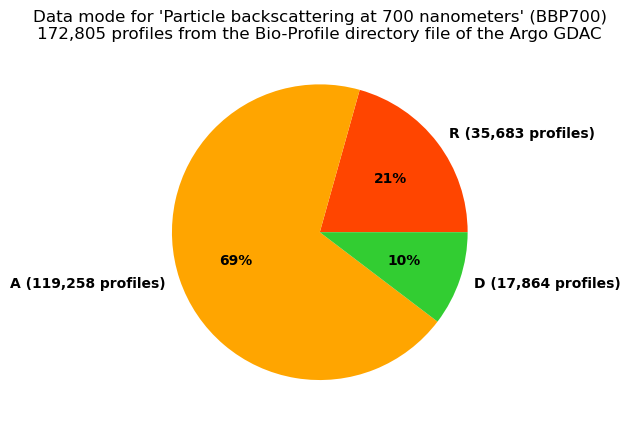

In [14]:
pf = lambda n: "{:,}".format(n)
autopct = lambda v: "%0.0f%%" % v

x = N.copy()
x.pop('')
if x[' '] == 0:
    x.pop(' ')
labels = ["%s (%s profiles)" % (k, pf(x[k])) for k in x.keys()]

fix, ax = plt.subplots()
ax.pie(x.values(), 
       labels=labels, 
       autopct=autopct, 
       colors=ArgoColors('data_mode').lookup.values(), 
       textprops=dict(weight="bold")
      );
ax.set_title("Data mode for '%s' (%s)\n%s profiles from the %s" % (param_info['prefLabel'], 
                                                                   param, 
                                                                   pf(idx.query.params(param).N_MATCH),
                                                                   idx.convention_title)
            );